In [1]:
import os

def adjust_wkdir(cut_folder='notebook'):
    abspath = os.path.abspath('.')
    wk_dir = abspath.replace(cut_folder,'')
    os.chdir(wk_dir)
    return wk_dir


adjust_wkdir()

'/share/felix/pj/lung_classify/'

In [2]:


import logging
logging.basicConfig(level=logging.INFO)

import pandas as pd
import os
from task_distribute.locker import task_locker
from file_cache.cache import file_cache, logger, timed

#from tqdm._tqdm_notebook import tqdm_notebook as  tqdm

from tqdm import tqdm, tqdm_notebook
from glob import glob
import itertools
import numpy as np
from easydict import EasyDict as edict

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)



INFO:root:Start the program at:amax3, 10.10.20.103, with:Load module


yes


In [3]:
df = pd.read_csv('./input/train_bboxes.csv')
gp = df.groupby('filename').x.count().sort_index()

count_img = len(glob('./input/train/*.jpg'))
print(df.shape, gp.shape, count_img)
df.head(3)

(7167, 5) (4509,) 20013


,filename,x,y,width,height
0,6,287.0,673.0,188.0,220.0
1,8,651.0,476.0,250.0,344.0
2,18,220.0,414.0,142.0,120.0


In [4]:
df = pd.read_csv('./input/train_bboxes.csv')
df = df.drop_duplicates('filename')
df['fold'] = df.filename%5
df.fold.value_counts()

INFO:numexpr.utils:Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


1    935
2    925
4    884
0    884
3    881
Name: fold, dtype: int64

In [5]:
df = pd.read_csv('./input/train.csv', names=['filename', 'label'])
#df.head()

df.label.value_counts()

0    15504
2     2450
1     1960
3       89
4       10
Name: label, dtype: int64

In [6]:
import matplotlib.pyplot as plt
from glob import glob

file_list = list(glob('./input/train/*.jpg'))[:8]
print(file_list)
img_list = [plt.imread (file) for file in file_list]


from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

fig = plt.figure(figsize=(20., 50.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2,4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 share_all=True,
                 )

for ax, im in zip(grid, img_list):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()

['./input/train/8755.jpg', './input/train/158.jpg', './input/train/1570.jpg', './input/train/4223.jpg', './input/train/312.jpg', './input/train/9240.jpg', './input/train/9708.jpg', './input/train/19325.jpg']


<Figure size 2000x5000 with 16 Axes>

In [31]:
import os
import numpy as np
import json
import cv2
import random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode
from functools import lru_cache

@lru_cache()
def get_anotation_dicts(fold=None, box_cnt=None):
    cls = pd.read_csv('./input/train.csv', names=['filename', 'label'])#.sample(100)
    cls['fold'] = cls.filename%5
    if fold:
        cls = cls.loc[cls.fold.isin(fold)]
    if box_cnt:
        df = pd.read_csv('./input/train_bboxes.csv')
        tmp = df.groupby('filename').filename.count().sort_values()
        tmp = tmp.loc[tmp==box_cnt]
        cls = cls.loc[cls.filename.isin(tmp.index)]
    
    bbox= pd.read_csv('./input/train_bboxes.csv')

    dataset_dicts = []
    for idx, v in tqdm(cls.iterrows(), position=0, desc=f'gen_annotaion_{str(fold)}', total=len(cls)):
        record = {}
        filename = v["filename"]
        #filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(f'input/train/{filename}.jpg').shape[:2]
        #print(height, width)
        
        record["file_name"] = f'input/train/{filename}.jpg'
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      

        objs = []
        for _, anno in bbox.loc[bbox.filename==v["filename"]].iterrows():
#             assert not anno["region_attributes"]
#             anno = anno["shape_attributes"]
#             px = anno["all_points_x"]
#             py = anno["all_points_y"]
#             poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
#             poly = [p for x in poly for p in x]
           
            if len(anno)>0 :
                #print(anno)
                obj = {
                    "bbox": [anno.x, anno.y, anno.width, anno.height],
                    "bbox_mode": BoxMode.XYWH_ABS,
                    "category_id": 0,
                    "thing_classes": 'bz',
                    "iscrowd": 0
                }
                objs.append(obj)
        if objs:
            record["annotations"] = objs
            dataset_dicts.append(record)
    print(f'dataset_dicts={len(dataset_dicts)}')
    return dataset_dicts



In [8]:


from detectron2.data import DatasetCatalog, MetadataCatalog
for d, folds in zip(["train", "val"], [(0,1,2,3), (4,)]):
    if "balloon_" + d not in DatasetCatalog.list():
        DatasetCatalog.register("balloon_" + d, lambda d=d: get_anotation_dicts(folds))
        MetadataCatalog.get("balloon_" + d).set(thing_classes=["bz"])
metadata = MetadataCatalog.get("balloon_train")

dataset_dicts = get_anotation_dicts((0,1,2,3))

gen_annotaion_(0, 1, 2, 3): 100%|██████████| 16011/16011 [05:51<00:00, 45.58it/s]

dataset_dicts=3625


In [9]:
#DatasetCatalog.list()

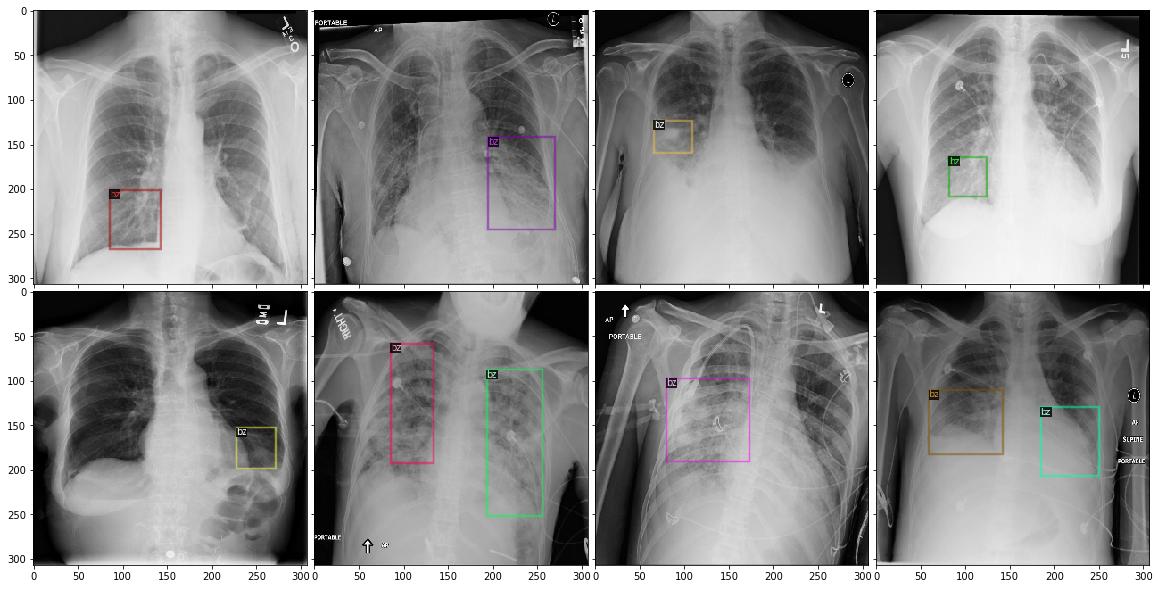

In [10]:
# Sample image, and show it

img_list =[]
for d in dataset_dicts[:8]:
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.3)
    vis = visualizer.draw_dataset_dict(d)
    #
    img_list.append(vis.get_image()[:, :, ::-1])

fig = plt.figure(figsize=(20., 50.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2,4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 share_all=True,
                 )

for ax, im in zip(grid, img_list):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()

In [11]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 3000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

INFO:detectron2.engine.defaults:Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Seq

gen_annotaion_(4,): 100%|██████████| 4002/4002 [01:08<00:00, 58.63it/s]
INFO:detectron2.data.build:Removed 0 images with no usable annotations. 884 images left.
INFO:detectron2.data.build:Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|     bz     | 1414         |
|            |              |
INFO:detectron2.data.detection_utils:TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
INFO:detectron2.data.build:Using training sampler TrainingSampler


dataset_dicts=884


INFO:fvcore.common.checkpoint:Loading checkpoint from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/retinanet_R_101_FPN_3x/138363263/model_final_59f53c.pkl
INFO:fvcore.common.file_io:URL https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/retinanet_R_101_FPN_3x/138363263/model_final_59f53c.pkl cached in /home/felix/.torch/fvcore_cache/detectron2/COCO-Detection/retinanet_R_101_FPN_3x/138363263/model_final_59f53c.pkl
INFO:fvcore.common.checkpoint:Reading a file from 'Detectron2 Model Zoo'
INFO:detectron2.engine.train_loop:Starting training from iteration 0
INFO:detectron2.utils.events:eta: 0:09:30  iter: 19  total_loss: 2.001  loss_cls: 1.470  loss_box_reg: 0.504  time: 0.1949  data_time: 0.0202  lr: 0.000005  max_mem: 3188M
INFO:detectron2.utils.events:eta: 0:09:38  iter: 39  total_loss: 1.775  loss_cls: 1.263  loss_box_reg: 0.516  time: 0.1987  data_time: 0.0053  lr: 0.000010  max_mem: 3188M
INFO:detectron2.utils.events:eta: 0:09:28  iter: 59  total_loss: 1.235  loss_cl

INFO:detectron2.utils.events:eta: 0:06:50  iter: 919  total_loss: 0.565  loss_cls: 0.321  loss_box_reg: 0.269  time: 0.2023  data_time: 0.0061  lr: 0.000230  max_mem: 3188M
INFO:detectron2.utils.events:eta: 0:06:46  iter: 939  total_loss: 0.546  loss_cls: 0.283  loss_box_reg: 0.263  time: 0.2021  data_time: 0.0066  lr: 0.000235  max_mem: 3188M
INFO:detectron2.utils.events:eta: 0:06:42  iter: 959  total_loss: 0.616  loss_cls: 0.363  loss_box_reg: 0.255  time: 0.2022  data_time: 0.0060  lr: 0.000240  max_mem: 3188M
INFO:detectron2.utils.events:eta: 0:06:39  iter: 979  total_loss: 0.575  loss_cls: 0.304  loss_box_reg: 0.279  time: 0.2024  data_time: 0.0065  lr: 0.000245  max_mem: 3188M
INFO:detectron2.utils.events:eta: 0:06:35  iter: 999  total_loss: 0.581  loss_cls: 0.314  loss_box_reg: 0.256  time: 0.2025  data_time: 0.0065  lr: 0.000250  max_mem: 3188M
INFO:detectron2.utils.events:eta: 0:06:32  iter: 1019  total_loss: 0.645  loss_cls: 0.346  loss_box_reg: 0.292  time: 0.2025  data_time

INFO:detectron2.utils.events:eta: 0:03:43  iter: 1879  total_loss: 0.583  loss_cls: 0.316  loss_box_reg: 0.274  time: 0.2034  data_time: 0.0057  lr: 0.000250  max_mem: 3188M
INFO:detectron2.utils.events:eta: 0:03:39  iter: 1899  total_loss: 0.451  loss_cls: 0.220  loss_box_reg: 0.211  time: 0.2035  data_time: 0.0059  lr: 0.000250  max_mem: 3188M
INFO:detectron2.utils.events:eta: 0:03:36  iter: 1919  total_loss: 0.551  loss_cls: 0.269  loss_box_reg: 0.257  time: 0.2035  data_time: 0.0064  lr: 0.000250  max_mem: 3188M
INFO:detectron2.utils.events:eta: 0:03:32  iter: 1939  total_loss: 0.477  loss_cls: 0.261  loss_box_reg: 0.217  time: 0.2036  data_time: 0.0066  lr: 0.000250  max_mem: 3188M
INFO:detectron2.utils.events:eta: 0:03:28  iter: 1959  total_loss: 0.496  loss_cls: 0.262  loss_box_reg: 0.234  time: 0.2036  data_time: 0.0061  lr: 0.000250  max_mem: 3188M
INFO:detectron2.utils.events:eta: 0:03:24  iter: 1979  total_loss: 0.570  loss_cls: 0.292  loss_box_reg: 0.231  time: 0.2036  data

INFO:detectron2.utils.events:eta: 0:00:32  iter: 2839  total_loss: 0.482  loss_cls: 0.277  loss_box_reg: 0.223  time: 0.2041  data_time: 0.0057  lr: 0.000250  max_mem: 3188M
INFO:detectron2.utils.events:eta: 0:00:28  iter: 2859  total_loss: 0.500  loss_cls: 0.288  loss_box_reg: 0.218  time: 0.2041  data_time: 0.0067  lr: 0.000250  max_mem: 3188M
INFO:detectron2.utils.events:eta: 0:00:24  iter: 2879  total_loss: 0.439  loss_cls: 0.245  loss_box_reg: 0.215  time: 0.2042  data_time: 0.0063  lr: 0.000250  max_mem: 3188M
INFO:detectron2.utils.events:eta: 0:00:20  iter: 2899  total_loss: 0.512  loss_cls: 0.279  loss_box_reg: 0.262  time: 0.2042  data_time: 0.0063  lr: 0.000250  max_mem: 3188M
INFO:detectron2.utils.events:eta: 0:00:16  iter: 2919  total_loss: 0.455  loss_cls: 0.245  loss_box_reg: 0.224  time: 0.2043  data_time: 0.0060  lr: 0.000250  max_mem: 3188M
INFO:detectron2.utils.events:eta: 0:00:12  iter: 2939  total_loss: 0.427  loss_cls: 0.226  loss_box_reg: 0.210  time: 0.2044  data

OrderedDict()

In [12]:
# from detectron2.engine import DefaultTrainer
# from detectron2.config import get_cfg

# cfg = get_cfg()
# cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_101_FPN_3x.yaml"))
# cfg.DATASETS.TRAIN = ("balloon_train",)
# cfg.DATASETS.TEST = ("balloon_val",)
# cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
# cfg.SOLVER.IMS_PER_BATCH = 2
# cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
# cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

# os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg) 
# trainer.resume_or_load(resume=False)
# trainer.train()

./output/model_final.pth


INFO:fvcore.common.checkpoint:Loading checkpoint from ./output/model_final.pth


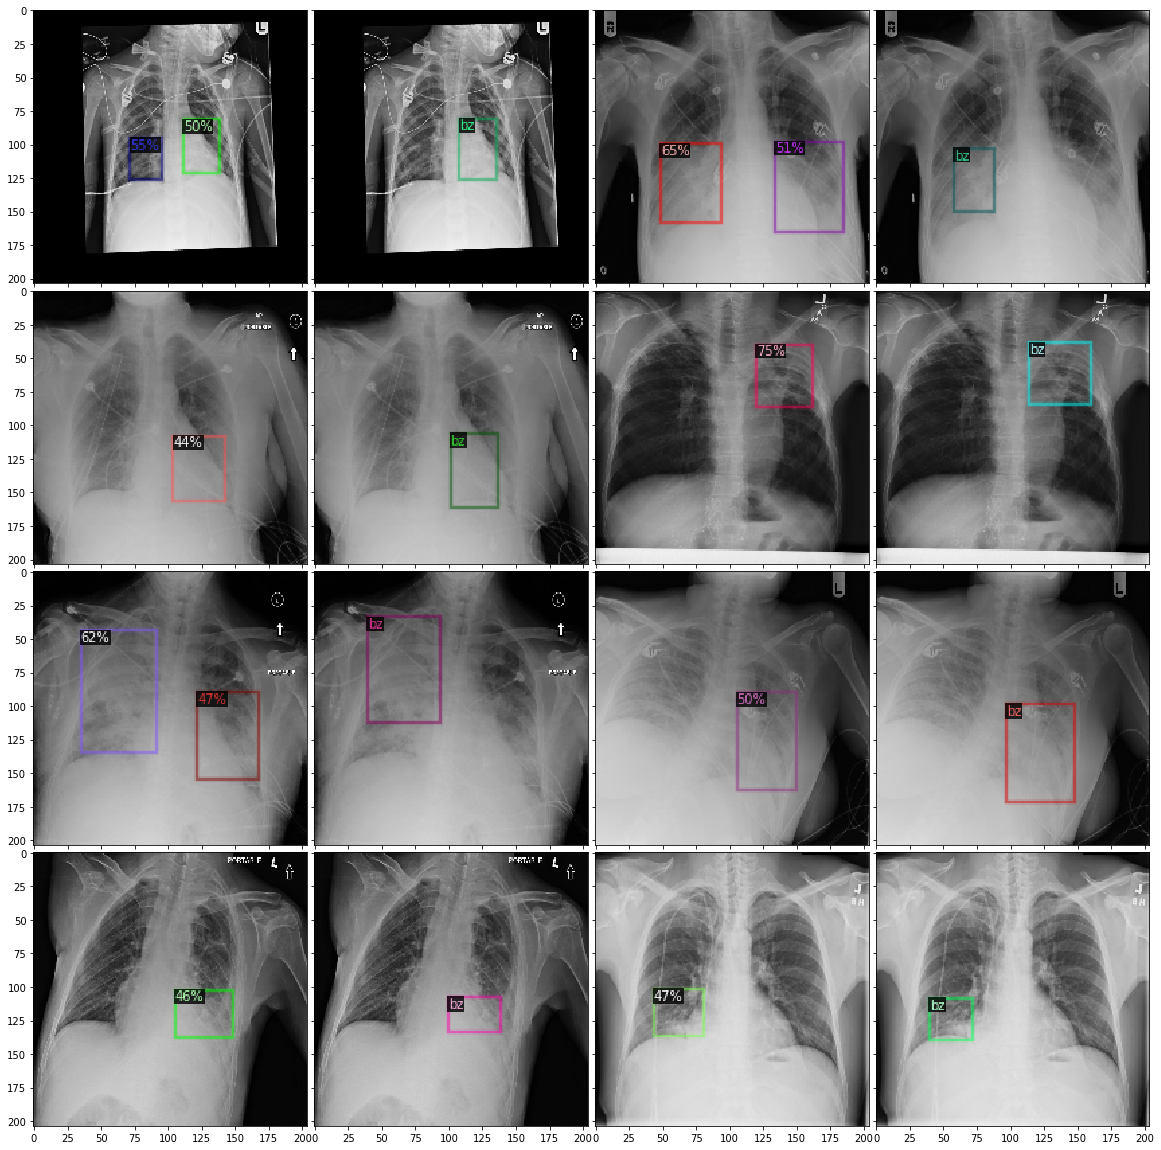

In [42]:
#https://detectron2.readthedocs.io/_modules/detectron2/modeling/meta_arch/retinanet.html

# Predict
# cfg = get_cfg()
# cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_101_FPN_3x.yaml"))
# cfg.DATASETS.TRAIN = ("balloon_train",)
# cfg.DATASETS.TEST = ("balloon_val",)
# cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
# cfg.SOLVER.IMS_PER_BATCH = 2
# cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
# cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)




cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
print(cfg.MODEL.WEIGHTS)
###cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.99   # set the testing threshold for this model
cfg.MODEL.RETINANET.SCORE_THRESH_TEST =0.4  # set threshold for retinanet
cfg.MODEL.RETINANET.NMS_THRESH_TEST =0.1
#cfg.TEST.DETECTIONS_PER_IMAGE = 2
cfg.DATASETS.TEST = ("balloon_val", )
predictor = DefaultPredictor(cfg)


import pydevd_pycharm

#pydevd_pycharm.settrace('192.168.1.100', port=1234, stdoutToServer=True, stderrToServer=True)

from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_anotation_dicts((4,) , box_cnt=1)

img_list= []
random.seed(2020)
for d in random.sample(dataset_dicts, min(8, len(dataset_dicts))):   
    #Predict Result
    im = cv2.imread(d["file_name"])
    file_list.append(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],  metadata=metadata,  scale=0.2, 
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu")) 
    img_list.append(v.get_image()[:, :, ::-1])
    #print(d["file_name"])
    
    #Ground Truth
    visualizer = Visualizer(im[:, :, ::-1], metadata=metadata, scale=0.2)
    vis = visualizer.draw_dataset_dict(d)
    img_list.append(vis.get_image()[:, :, ::-1])

    
fig = plt.figure(figsize=(20., 50.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4,4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 share_all=True,
                 )

for ax, im in zip(grid, img_list):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()



Int64Index([5072, 15936, 14509, 10833, 8955, 13230, 2014, 12843, 16953, 16987], dtype='int64', name='filename')

In [15]:
cls = pd.read_csv('./input/train.csv', names=['filename', 'label'])
cls.label.value_counts()

0    15504
2     2450
1     1960
3       89
4       10
Name: label, dtype: int64

In [16]:

# img_list = []
# #Print Ground Truth
# for file in file_list:

#     img = cv2.imread(file)
#     visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.3)
#     vis = visualizer.draw_dataset_dict(d)
 
#     img_list.append(vis.get_image()[:, :, ::-1])


    
# fig = plt.figure(figsize=(20., 50.))
# grid = ImageGrid(fig, 111,  # similar to subplot(111)
#                  nrows_ncols=(2,4),  # creates 2x2 grid of axes
#                  axes_pad=0.1,  # pad between axes in inch.
#                  share_all=True,
#                  )

# for ax, im in zip(grid, img_list):
#     # Iterating over the grid returns the Axes.
#     ax.imshow(im)
# plt.show()

In [43]:
enumerate?